<a href="https://colab.research.google.com/github/AdrianHerczeg/NLP_job_matching/blob/master/Towards_an_end_to_end_system_to_match_resumes_and_job_descriptions(experimental_results)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pdfminer.six

In [2]:
!pip install word2number

In [3]:
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [4]:
!pip install unidecode

In [5]:
!git clone https://github.com/AdrianHerczeg/NLP_job_matching

fatal: destination path 'NLP_job_matching' already exists and is not an empty directory.


In [0]:
#Extracting text from pdf
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import BytesIO


def pdf_to_text(path):
    """
    Extracts the text from the PDF document located on the path given as the argument,
    and returns the extracted text.

    Attributes
    ----------

    path : str
      the path to the respective document
    """

    manager = PDFResourceManager()
    retstr = BytesIO()
    layout = LAParams(all_texts=True)
    device = TextConverter(manager, retstr, laparams=layout)
    filepath = open(path, 'rb')
    interpreter = PDFPageInterpreter(manager, device)

    for page in PDFPage.get_pages(filepath, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    filepath.close()
    device.close()
    retstr.close()
    return text.decode('utf-8')

In [0]:
import spacy    #for text preprocessing and entity extraction

#Load the general model for the english language
nlp = spacy.load('en_core_web_md')

In [0]:
#preprocess text 
from unidecode import unidecode
from word2number import w2n



#converting to lower cases
def convert_to_lower(text: str):
    return (str(text)).lower()


#removing accented characters
def remove_accented_chars(text):
    text = unidecode(text)
    return text

#converting numbers to words
def convert_number_to_words(token):
    try:
        x = str(w2n.word_to_num(token))
        return x
    except ValueError:
        return token

#removing extra white spaces
def remove_whitespaces(text):
    text = text.strip()
    return " ".join(text.split())



def preprocess_text(resume):
    resume = convert_to_lower(resume)

    resume = remove_accented_chars(resume)

    resume = remove_whitespaces(resume)

    doc = nlp(resume)

    tokens = []

    for token in doc:                       #tokenization
        add = True                
        text = token.lemma_                 #lemmantization
        if token.pos_ == 'NUM':
            text = convert_number_to_words(text)
            add = True
        if token.pos_ == 'PUNCT':           #eliminating punctuations
            add = False
        if token.is_stop:                   #eliminating stop words
            add = False
        if token.pos_ == 'SYM':             #eliminating special characters
            add = False
        if add:
            tokens.append(text)
            add = True

    parsed_resume = " "

    return parsed_resume.join(tokens)


In [9]:
import pandas as pd     #for data visualization


categories = pd.read_csv('/content/NLP_job_matching/Data/abilities.csv')
categories

,Statistics,Machine Learning,Deep Learning,R Language,Python Language,NLP,Data Engineering
0,statistical models,linear regression,neural network,ggplot,python,nlp,aws
1,statistical modeling,logistic regression,keras,shiny,flask,natural language processing,ec2
2,probability,K means,theano,cran,django,topic modeling,amazon redshift
3,normal distribution,random forest,face detection,dplyr,pandas,lda,s3
4,poisson distribution,xgboost,neural networks,tidyr,numpy,named entity recognition,docker
5,survival models,svm,convolutional neural network(cnn),lubricate,scikitlearn,pos tagging,kubernets
6,hypothesis testing,naive bayes,recurent neural network(RNN),knitr,sklearn,word2vec,scala
7,bayesian inference,pca,object detection,NaN,matplotlib,word embedding,teradata
8,factor analysis,decision tree,yolo,NaN,scipy,lsi,google big query
9,forecasting,svd,gpu,NaN,bokeh,spacy,aws lambda


In [0]:
#skills
from spacy.matcher import PhraseMatcher   #for entity extraction
import numpy as np                        #for mathematical calculations



def is_nan(x):
    return x is np.nan or x != x



def get_skills(resume):
    skills = {}
    doc = nlp(resume)
    for category in categories:
        matched_skills = []
        terms = [term for term in categories[category]
                 if is_nan(term) == False]
        patterns = [nlp.make_doc(text) for text in terms]
        matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
        matcher.add("TerminologyList", None, *patterns)
        matches = matcher(doc)

        for match_id, start, end in matches:
            span = doc[start:end]
            matched_skills.append(str(span))
        skills[category] = matched_skills
    return skills



def in_skills(text, job_description):
    skills = get_skills(job_description)
    preprocessed_text = preprocess_text(text)
    for key in skills.keys():
        if preprocessed_text in skills[key]:
            return True
    return False

In [0]:
#score calculation formula
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


#creating the vectors with the TH-IDF values
def match_resume_job_description(job_description, resume):

    preprocessed_resume = preprocess_text(resume)

    preprocessed_job_description = preprocess_text(job_description)

    corpus = [preprocessed_job_description, preprocessed_resume]

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)

    feature_names = vectorizer.get_feature_names()
    dense = X.todense()
    denselist = dense.tolist()

    df = pd.DataFrame(denselist, columns=feature_names,
                      index=['Job Description', 'Resume'])

    selected_skills = pd.DataFrame()

    for category in categories.columns:
        for term in categories[category]:
            if not is_nan(term):
                if in_skills(term, preprocessed_job_description):
                    selected_skills = pd.concat(
                        [selected_skills, df[term]], axis=1)

    return selected_skills


#calculating the score
def calculate_match_score(dataframe_score: type(pd.DataFrame())):
    
    if len(dataframe_score.columns) != 0:
        score = cosine_similarity(dataframe_score[0:1], dataframe_score)
        return score
    return [[0,0]]



def match_and_calculate(job_description, resume):
    matched_frame = match_resume_job_description(job_description, resume)
    return (calculate_match_score(matched_frame))[0][1]




In [12]:
import os               #used to manage the data

path = os.path.join('NLP_job_matching','Data','Matches')
dirs = os.listdir(path)
dirs

['Candidatul_ideal##03-04-2020  18-06-16',
 'Job_Description_3##03-04-2020  18-11-36.pdf',
 'We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16',
 'Candidatul_ideal##03-04-2020  18-06-16.pdf',
 'Job_Description_3##03-04-2020  18-11-36',
 'We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16.pdf']

In [0]:
#storing the data in a dictionary for easier access
documents = {}

for dir in dirs:
  if '.pdf' in dir:
 
    job_description_path = os.path.join(path,dir)
    job_description_text = pdf_to_text(job_description_path)
    
    job_description = {}
    job_description['file_name'] = dir
    job_description['text'] = job_description_text


    resumes_folder = job_description_path.split('.pdf')[0]    
    resumes_files = os.listdir(resumes_folder)
 
    set_name = dir.split('.pdf')[0]+"_SET"

    batch = {}
    resumes = []
    for resume_file in resumes_files:
      resume = {}
      resume['file_name'] = resume_file
      resume['text'] = pdf_to_text(os.path.join(resumes_folder,resume_file))
      resumes.append(resume)
    
    batch['job_description'] = job_description
    batch['resumes'] = resumes  

    documents[set_name] = batch  

In [14]:
import json

print(json.dumps(documents,indent = 4))

{
    "Job_Description_3##03-04-2020  18-11-36_SET": {
        "job_description": {
            "file_name": "Job_Description_3##03-04-2020  18-11-36.pdf",
            "text": " \n\n \n\n \n\n \n\n \n\n \n\nDescrierea jobului \n\nResponsibilities \n\nand orchestration. \n\nRequirements \n\nCandidatul ideal \n\neMAG is looking for a highly motivated colleague to join our AntiSpiders team as Data Scientist. \n\nOur team analyses web traffic, identifies non-human agents (crawlers, search engines) and \n\ndevelops pipelines for filtering data used by the Business Intelligence department. \n\nWe have built our applications with Spark, Kafka, BigQuery, and Airflow. They are mostly written in \n\nPython and deployed using Docker on a hybrid infrastructure (own machines and Google Cloud) \n\nYou will analyze large-scale datasets and build machine learning models to enhance spider \n\ndetection. These models will be integrated in our production pipelines. \n\nDiscover, interpret and document un

In [15]:
#the TF-IDF measure for one pair resume-job description
random_position = np.random.randint(len(documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes']))
print(random_position)

j_d = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['job_description']['text']
resume_1 = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes'][random_position]['text']
match_resume_job_description(j_d,resume_1)

69


,python,docker,hive,hadoop,sql
Job Description,0.054998,0.054998,0.054998,0.054998,0.039132
Resume,0.000000,0.000000,0.000000,0.000000,0.099650


#Dataset and experimets

Our dataset is composed from 220 resumes, the same dataset provided by (https://www.kaggle.com/dataturks/resume-entities-for-ner), we converted the json document provided by the author in 220 pdf resumes. We use two dictionaries for testing, The tests we conducted are as folows:
- first we use small sentences instead of resumes and job descriptions to demonstrate the functionality behind the ranking alorithm. We test them using b two dictionaries, one that is correctly formed (contains many keywords) and one that is incorrrectly formed (contains very few words, some of them not being relevant). We measure the total time check the functionality of the alghoritm.

- second we split all the 220 resumes across three diffrent job descriptions in aproximatly equal proportions, and measure the total time necesary. We also compare the resumes from the top ranks with the ones from the bottom.

- finally, we combine all the 220 resumes together and create the ranking for every job description. 



In [0]:
def apply_matching_alghorim(job_description_text : str, resume_text : str):
  match = match_and_calculate(job_description_text, resume_text)
  return match

In [0]:
from timeit import default_timer as timer
from pprint import pprint

##First experiment



In [0]:
job_description_first_experiment = "Wa are looking for a data scientist with knowledge in python, keras, nlp statistical models. and tensorflow."

first_resume = "Ive worked as a banker for the last 8 years, I have a vast understanding of the concepts in the financial domain and experience working with people."

second_resume = "I've worked as a web developer, I've been using python, mainly Flask an Jango, I also have experience as front-end designer."

third_resume = "I worked as a python developer for 3 years, I've been using mainly flask and Jango, and have beginer knowledge of keras."

forth_resume = "I worked as a data scientist for 5 years, I have 3 years experience of python and tensorflow, knowledge of keras and experience with nlp and statistical models."

fifth_resume = "I worked as a java developer for the last 10 years, I have prior experience with neural networks implementations in java and a vast knowledge of keras."


###With a more complete dictionary.

In [0]:
categories = pd.read_csv('/content/NLP_job_matching/Data/abilities.csv')

In [20]:


scores = []
times = []

first_resume_score = {}
first_resume_score['resume_name'] = 'first resume'
start = timer()
first_resume_score['score'] = match_and_calculate(job_description= job_description_first_experiment,resume = first_resume)
end = timer()
scores.append(first_resume_score)
times. append({
    'resume':'first resume',
    'time (seconds)':end-start,
    'number of words':len(nlp(first_resume))
})



second_resume_score = {}
second_resume_score['resume_name'] = 'second resume'
start = timer()
second_resume_score['score'] = match_and_calculate(job_description= job_description_first_experiment,resume = second_resume)
end = timer()
scores.append(second_resume_score)
times. append({
    'resume':'second resume',
    'time (seconds)':end-start,
    'number of words':len(nlp(second_resume))
})



third_resume_score = {}
third_resume_score['resume_name'] = 'third resume'
start = timer()
third_resume_score['score'] = match_and_calculate(job_description= job_description_first_experiment,resume = third_resume)
end = timer()
scores.append(third_resume_score)
times. append({
    'resume':'third resume',
    'time (seconds)':end-start,
    'number of words':len(nlp(third_resume))
})



forth_resume_score = {}
forth_resume_score['resume_name'] = 'forth resume'
start = timer()
forth_resume_score['score'] = match_and_calculate(job_description= job_description_first_experiment,resume = forth_resume)
end = timer()
scores.append(forth_resume_score)
times. append({
    'resume':'forth resume',
    'time (seconds)':end-start,
    'number of words':len(nlp(forth_resume))
})


fifth_resume_score = {}
fifth_resume_score['resume_name'] = 'fifth resume'
start = timer()
fifth_resume_score['score'] = match_and_calculate(job_description= job_description_first_experiment,resume = fifth_resume)
end = timer()
scores.append(fifth_resume_score)
times. append({
    'resume':'fifth resume',
    'time (seconds)':end-start,
    'number of words':len(nlp(fifth_resume))
})


scores.sort(reverse = True, key = lambda x: x['score'])
for score in scores:
  print("""{} : {}""".format(score['resume_name'], score['score']))

print()

for time in times:
  print(
"""
{}, has {} words and a necesary time for calculation of {:.2f} seconds  
""".format(time['resume'],time['number of words'], time['time (seconds)'])
)


forth resume : 1.0
third resume : 0.5797386715376656
second resume : 0.3799783615910079
fifth resume : 0.37997836159100784
first resume : 0.0


first resume, has 30 words and a necesary time for calculation of 1.73 seconds  


second resume, has 29 words and a necesary time for calculation of 1.67 seconds  


third resume, has 26 words and a necesary time for calculation of 1.69 seconds  


forth resume, has 31 words and a necesary time for calculation of 1.69 seconds  


fifth resume, has 29 words and a necesary time for calculation of 1.69 seconds  



As can be seen above, the alghoritm manages to rank corectly the texts based on the mentioned skills and their similarity to their job description. For the resumes with the same number of keywords, the score may differ within a very small margin. 

###With a diffrent, smaller dictionary with less representative words.

In [0]:
bad_keywords  = {'Keywords':['keras','statistical models','architecture','car','building','cat','financial','people']}
categories = pd.DataFrame(bad_keywords)

In [34]:
categories

,Keywords
0,keras
1,statistical models
2,architecture
3,car
4,building
5,cat
6,financial
7,people


In [35]:

scores = []
times = []

first_resume_score = {}
first_resume_score['resume_name'] = 'first resume'
start = timer()
first_resume_score['score'] = match_and_calculate(job_description= job_description_first_experiment,resume = first_resume)
end = timer()
scores.append(first_resume_score)
times. append({
    'resume':'first resume',
    'time (seconds)':end-start,
    'number of words':len(nlp(first_resume))
})



second_resume_score = {}
second_resume_score['resume_name'] = 'second resume'
start = timer()
second_resume_score['score'] = match_and_calculate(job_description= job_description_first_experiment,resume = second_resume)
end = timer()
scores.append(second_resume_score)
times. append({
    'resume':'second resume',
    'time (seconds)':end-start,
    'number of words':len(nlp(second_resume))
})



third_resume_score = {}
third_resume_score['resume_name'] = 'third resume'
start = timer()
third_resume_score['score'] = match_and_calculate(job_description= job_description_first_experiment,resume = third_resume)
end = timer()
scores.append(third_resume_score)
times. append({
    'resume':'third resume',
    'time (seconds)':end-start,
    'number of words':len(nlp(third_resume))
})



forth_resume_score = {}
forth_resume_score['resume_name'] = 'forth resume'
start = timer()
forth_resume_score['score'] = match_and_calculate(job_description= job_description_first_experiment,resume = forth_resume)
end = timer()
scores.append(forth_resume_score)
times. append({
    'resume':'forth resume',
    'time (seconds)':end-start,
    'number of words':len(nlp(forth_resume))
})


fifth_resume_score = {}
fifth_resume_score['resume_name'] = 'fifth resume'
start = timer()
fifth_resume_score['score'] = match_and_calculate(job_description= job_description_first_experiment,resume = fifth_resume)
end = timer()
scores.append(fifth_resume_score)
times. append({
    'resume':'fifth resume',
    'time (seconds)':end-start,
    'number of words':len(nlp(fifth_resume))
})


scores.sort(reverse = True, key = lambda x: x['score'])

for score in scores:
  print("""{} : {}""".format(score['resume_name'], score['score']))

print()

for time in times:
  print(
"""
{}, has {} words and a necesary time for calculation of {:.2f} seconds  
""".format(time['resume'],time['number of words'], time['time (seconds)'])
)


third resume : 1.0
forth resume : 1.0
fifth resume : 1.0
first resume : 0.0
second resume : 0.0


first resume, has 30 words and a necesary time for calculation of 0.16 seconds  


second resume, has 29 words and a necesary time for calculation of 0.16 seconds  


third resume, has 26 words and a necesary time for calculation of 0.16 seconds  


forth resume, has 31 words and a necesary time for calculation of 0.16 seconds  


fifth resume, has 29 words and a necesary time for calculation of 0.16 seconds  



As can be seen above the, the algorithm is heavily dependent on the dictionary, the order being completly changed based on the keywords list.

##Second experiment

###First job description results

In [0]:
categories = pd.read_csv('/content/NLP_job_matching/Data/abilities.csv')

In [37]:
#applying the algohirm for one resume and one job description
random_position = np.random.randint(len(documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes']))
job_description_sample = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['job_description']['text']
job_description_nlp = nlp(job_description_sample)



resume_sample = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes'][random_position]['text']
resume_nlp = nlp(resume_sample)

start = timer()
match = match_and_calculate(job_description,resume)
end = timer()

time = end - start

print("Statistics for matching one resume and one job description")
print("""For: 
one job description with {} words 
and one resume with {} words, 
the necesary time for calculating the matching score is {:.2f}""".
format(len(job_description_nlp),
                len(resume_nlp),
                time
        ))



Statistics for matching one resume and one job description
For: 
one job description with 588 words 
and one resume with 581 words, 
the necesary time for calculating the matching score is 5.06


In [0]:
times_for_matches_job_description_1 = []

In [0]:
times_for_matches_job_description_2 = []

In [0]:
times_for_matches_job_description_3 = []

In [41]:
#applying the alghoritm for all resumes associated with one job description

job_description_sample = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['job_description']['text']
job_description_nlp = nlp(job_description_sample)

resumes = {}


for i in range(len(documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes'])):
  
  resume = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes'][i]

  resume_details = {}
  resume_details['resume_text'] = resume['text']

  resume_nlp = nlp(resume['text'])
  resume_details['word_numbers'] = len(resume_nlp)
  
  resumes[resume['file_name']] = resume_details


total_words = 0
for key in resumes.keys():
  total_words = total_words + resumes[key]['word_numbers']


average_words = total_words / (len(documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes']))
average_words


start = timer()

for key in resumes.keys():
  resume_text = resumes[key]['resume_text']
  score = match_and_calculate(job_description_sample,resume_text)
  resumes[key]['compatibility_score'] = score

end = timer()
total_time = end - start
average_time = total_time / len(resumes.keys())


print(
"""On one job description with {} words and 
{} resume with an average of {} words / resume,
the total necesary time is {} minutes, 
with an average of {} seconds / match calculation""".format(
    len(job_description_nlp),
    len(resumes.keys()),
    average_words,
    total_time/60,
    average_time

))
  

On one job description with 588 words and 
74 resume with an average of 748.7027027027027 words / resume,
the total necesary time is 6.818916289733331 minutes, 
with an average of 5.528851045729728 seconds / match calculation


In [42]:
job_description_sample = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['job_description']['text']
job_description_nlp = nlp(job_description_sample)

total_time = 0




for i in range(len(documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes'])):
  
  resume = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['resumes'][i]
  start = timer()
  score = match_and_calculate(job_description_sample, resume['text'])
  end = timer()
  total_time = total_time + (end - start)
  times_for_matches_job_description_1.append(total_time)

print(times_for_matches_job_description_1)




[5.483430334000104, 11.18010974899994, 16.831998069000065, 22.376513768999985, 28.07222303200001, 33.564565381999955, 38.93916230500008, 44.40114226600008, 49.85694016100001, 55.35966717600013, 60.80245786400019, 66.20897964400024, 71.64042673900008, 77.11374582100007, 82.65251040899989, 88.02680939899983, 93.4006986559998, 98.79903724199971, 104.2276998389998, 109.63179754399971, 115.28342123899984, 120.70675717599988, 126.16857021499982, 131.64203817599991, 137.10776475600005, 142.60604648900016, 148.0403307600002, 153.48816688100032, 158.99361838200025, 164.5323906360004, 170.03873020000037, 175.5683885310002, 181.18891713200037, 186.62406812700033, 192.07339360400033, 197.5297056510003, 203.06694330000028, 208.5876332690002, 214.05009027400024, 219.4483732030003, 224.97876030900034, 230.41480369500027, 235.94039249100024, 241.38783611100007, 246.88317365600005, 252.36993723299997, 257.87071966999997, 263.43121757799986, 268.905598908, 274.37765654299983, 279.8093918999998, 285.2722

###Second job description

In [43]:
#applying the alghoritm for all resumes associated with one job description

job_description_sample = documents["Job_Description_3##03-04-2020  18-11-36_SET"]['job_description']['text']
job_description_nlp = nlp(job_description_sample)

resumes = {}


for i in range(len(documents["Job_Description_3##03-04-2020  18-11-36_SET"]['resumes'])):
  
  resume = documents["Job_Description_3##03-04-2020  18-11-36_SET"]['resumes'][i]

  resume_details = {}
  resume_details['resume_text'] = resume['text']

  resume_nlp = nlp(resume['text'])
  resume_details['word_numbers'] = len(resume_nlp)
  
  resumes[resume['file_name']] = resume_details


total_words = 0
for key in resumes.keys():
  total_words = total_words + resumes[key]['word_numbers']


average_words = total_words / (len(documents["Job_Description_3##03-04-2020  18-11-36_SET"]['resumes']))



start = timer()

for key in resumes.keys():
  resume_text = resumes[key]['resume_text']
  score = match_and_calculate(job_description_sample,resume_text)
  resumes[key]['compatibility_score'] = score

end = timer()
total_time = end - start
average_time = total_time / len(resumes.keys())


print(
"""On one job description with {} words and 
{} resume with an average of {} words / resume,
the total necesary time is {} minutes, 
with an average of {} seconds / match calculation""".format(
    len(job_description_nlp),
    len(resumes.keys()),
    average_words,
    total_time/60,
    average_time

))
  

On one job description with 416 words and 
76 resume with an average of 720.4868421052631 words / resume,
the total necesary time is 5.690529645283334 minutes, 
with an average of 4.492523404171053 seconds / match calculation


In [44]:
job_description_sample = documents["Job_Description_3##03-04-2020  18-11-36_SET"]['job_description']['text']
job_description_nlp = nlp(job_description_sample)

total_time = 0




for i in range(len(documents["Job_Description_3##03-04-2020  18-11-36_SET"]['resumes'])):
  resume = documents["Job_Description_3##03-04-2020  18-11-36_SET"]['resumes'][i]
  start = timer()
  score = match_and_calculate(job_description_sample, resume['text'])
  end = timer()
  total_time = total_time + (end - start)
  times_for_matches_job_description_2.append(total_time)

print(times_for_matches_job_description_2)


[4.4540017819999775, 8.910860684999989, 13.35996179499989, 17.75270155399994, 22.426408189999847, 26.89902280699971, 31.350991801999726, 35.812013379999826, 40.24280483099983, 44.76265257499972, 49.160470891999694, 53.53217267099967, 57.85880447799968, 62.37713182199968, 66.73192879299972, 71.07513393999966, 75.46433813999988, 79.83606548799958, 84.20295051699964, 88.60159063599963, 92.97876556299957, 97.33544483399987, 101.78653026200004, 106.18770260499991, 110.61272611499976, 114.99521425699936, 119.40918216799923, 123.90009218799946, 128.26952534599945, 132.74906661499904, 137.19568751199927, 141.74664066699893, 146.31803176799917, 150.723529662999, 155.19140596599914, 159.7590585369992, 164.22427439499938, 168.911073996999, 173.74907847899863, 178.15266111099822, 182.65279739999846, 187.04501094399825, 191.59750439499817, 196.1747531369981, 200.59079287299778, 204.9826593859982, 209.52661374499826, 214.25739183999826, 218.78724712899816, 223.21661926299817, 227.62308622799787, 232

###Third job description

In [45]:
#applying the alghoritm for all resumes associated with one job description

job_description_sample = documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['job_description']['text']
job_description_nlp = nlp(job_description_sample)

resumes = {}


for i in range(len(documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['resumes'])):
  
  resume = documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['resumes'][i]

  resume_details = {}
  resume_details['resume_text'] = resume['text']

  resume_nlp = nlp(resume['text'])
  resume_details['word_numbers'] = len(resume_nlp)
  
  resumes[resume['file_name']] = resume_details


total_words = 0
for key in resumes.keys():
  total_words = total_words + resumes[key]['word_numbers']


average_words = total_words / (len(documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['resumes']))
average_words


start = timer()

for key in resumes.keys():
  resume_text = resumes[key]['resume_text']
  score = match_and_calculate(job_description_sample,resume_text)
  resumes[key]['compatibility_score'] = score

end = timer()
total_time = end - start
average_time = total_time / len(resumes.keys())


print(
"""On one job description with {} words and 
{} resume with an average of {} words / resume,
the total necesary time is {} minutes, 
with an average of {} seconds / match calculation""".format(
    len(job_description_nlp),
    len(resumes.keys()),
    average_words,
    total_time/60,
    average_time

))
  

On one job description with 416 words and 
70 resume with an average of 701.7 words / resume,
the total necesary time is 4.999615259799998 minutes, 
with an average of 4.285384508399998 seconds / match calculation


In [46]:
job_description_sample = documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['job_description']['text']
job_description_nlp = nlp(job_description_sample)

total_time = 0




for i in range(len(documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['resumes'])):
  resume = documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['resumes'][i]
  start = timer()
  score = match_and_calculate(job_description_sample, resume['text'])
  end = timer()
  total_time = total_time + (end - start)
  times_for_matches_job_description_3.append(total_time)

print(times_for_matches_job_description_3)


[4.216552669000066, 8.402011565000066, 12.6048985489997, 16.82246292199943, 21.356482566999603, 25.551640769999267, 29.778535878999264, 33.97015277099899, 38.16488454699902, 42.289247930998954, 46.49212438099903, 50.729554174999066, 55.10177059899934, 59.314752474999295, 63.47784505199934, 67.75971985499928, 71.94959800099923, 76.17882610199922, 80.35846046299912, 84.54010140499895, 88.78564550699912, 92.91954125099892, 97.06477856599895, 101.29405948199883, 105.47456091799859, 109.7411393139987, 114.0416113479987, 118.1866199219985, 122.33096761699835, 126.43351443299798, 130.57037654899796, 134.70774156299785, 138.82963023799812, 143.04495763399837, 147.22495099099842, 151.45997817399848, 155.6068359389983, 159.81558341999835, 164.09457776099862, 168.28155204199857, 172.44391678099828, 176.88347331399837, 181.09337659499852, 185.31631593399834, 189.46840927199855, 193.82750597499853, 198.10550157899843, 202.31676442299886, 206.4946944139988, 210.8473318479987, 215.0243261939986, 219.

In [47]:
print(times_for_matches_job_description_1)
print(times_for_matches_job_description_2)
print(times_for_matches_job_description_3)

[5.483430334000104, 11.18010974899994, 16.831998069000065, 22.376513768999985, 28.07222303200001, 33.564565381999955, 38.93916230500008, 44.40114226600008, 49.85694016100001, 55.35966717600013, 60.80245786400019, 66.20897964400024, 71.64042673900008, 77.11374582100007, 82.65251040899989, 88.02680939899983, 93.4006986559998, 98.79903724199971, 104.2276998389998, 109.63179754399971, 115.28342123899984, 120.70675717599988, 126.16857021499982, 131.64203817599991, 137.10776475600005, 142.60604648900016, 148.0403307600002, 153.48816688100032, 158.99361838200025, 164.5323906360004, 170.03873020000037, 175.5683885310002, 181.18891713200037, 186.62406812700033, 192.07339360400033, 197.5297056510003, 203.06694330000028, 208.5876332690002, 214.05009027400024, 219.4483732030003, 224.97876030900034, 230.41480369500027, 235.94039249100024, 241.38783611100007, 246.88317365600005, 252.36993723299997, 257.87071966999997, 263.43121757799986, 268.905598908, 274.37765654299983, 279.8093918999998, 285.2722

In [0]:
import matplotlib.pyplot as plt


###Charts

In [0]:
number_of_resumes_1 = [i+1 for i in range(len(times_for_matches_job_description_1))]
number_of_resumes_2 = [i+1 for i in range(len(times_for_matches_job_description_2))]
number_of_resumes_3 = [i+1 for i in range(len(times_for_matches_job_description_3))]



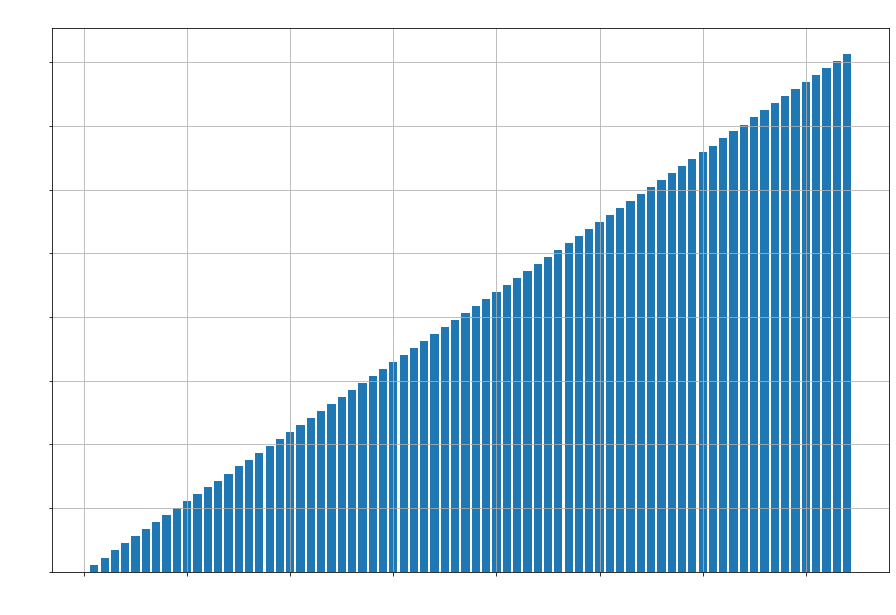

In [50]:
plt.figure(figsize = (15, 10))
plt.xlabel("Number of resumes", fontdict={'size' : 15, 'color':'white'})
plt.ylabel("Time to process", fontdict = {'size' : 15, 'color':'white'})
plt.title("Time complexity for the first job description", 
          fontdict = {'size': 20,
                      'color':'white'})
plt.grid("True")
plt.xticks(color = 'white')
plt.yticks(color = 'white')

plt.bar(number_of_resumes_1,times_for_matches_job_description_1)
plt.savefig('experiment_2_first_resume.png')

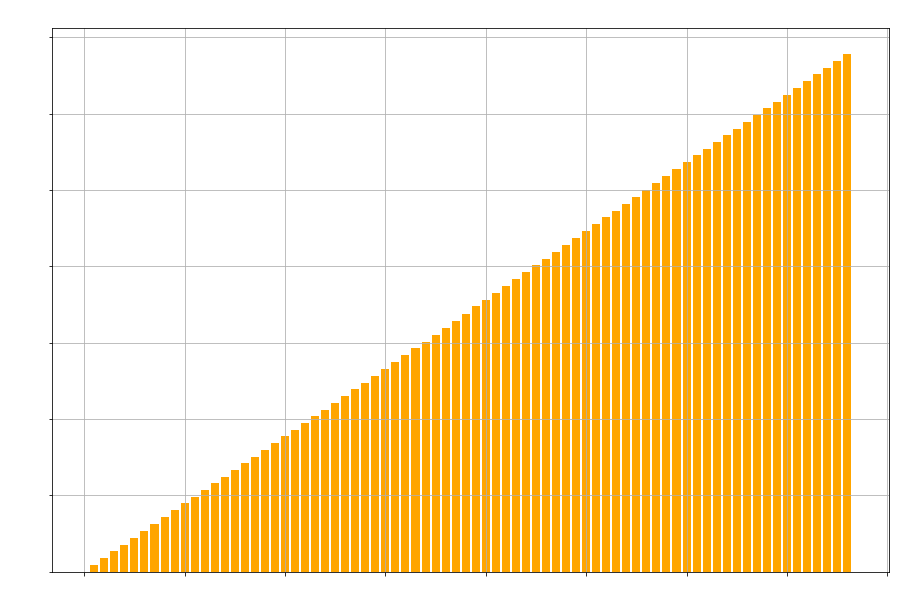

In [51]:
plt.figure(figsize = (15, 10))
plt.xlabel("Number of resumes", fontdict={'size' : 15, 'color':'white'})
plt.ylabel("Time to process", fontdict = {'size' : 15, 'color':'white'})
plt.title("Time complexity for the second job description", 
          fontdict = {'size': 20,
                      'color':'white'})
plt.grid("True")
plt.xticks(color = 'white')
plt.yticks(color = 'white')

plt.bar(number_of_resumes_2,times_for_matches_job_description_2, color = 'orange')
plt.savefig('experiment_2_second_resume.png')

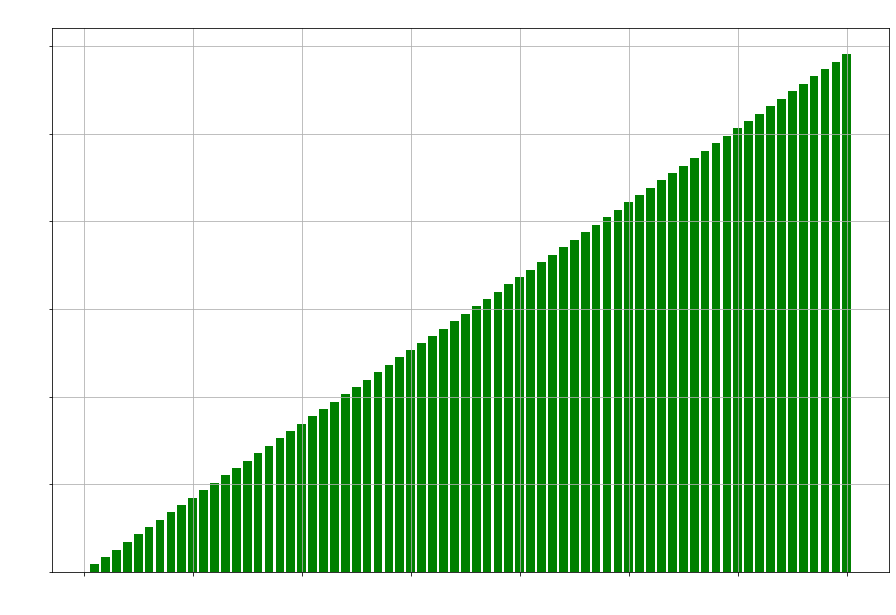

In [52]:
plt.figure(figsize = (15, 10))
plt.xlabel("Number of resumes", fontdict={'size' : 15, 'color':'white'})
plt.ylabel("Time to process", fontdict = {'size' : 15, 'color':'white'})
plt.title("Time complexity for the third job description", 
          fontdict = {'size': 20,
                      'color':'white'})
plt.grid("True")
plt.xticks(color = 'white')
plt.yticks(color = 'white')

plt.bar(number_of_resumes_3,times_for_matches_job_description_3,color = 'green')
plt.savefig('experiment_2_third_resume.png')

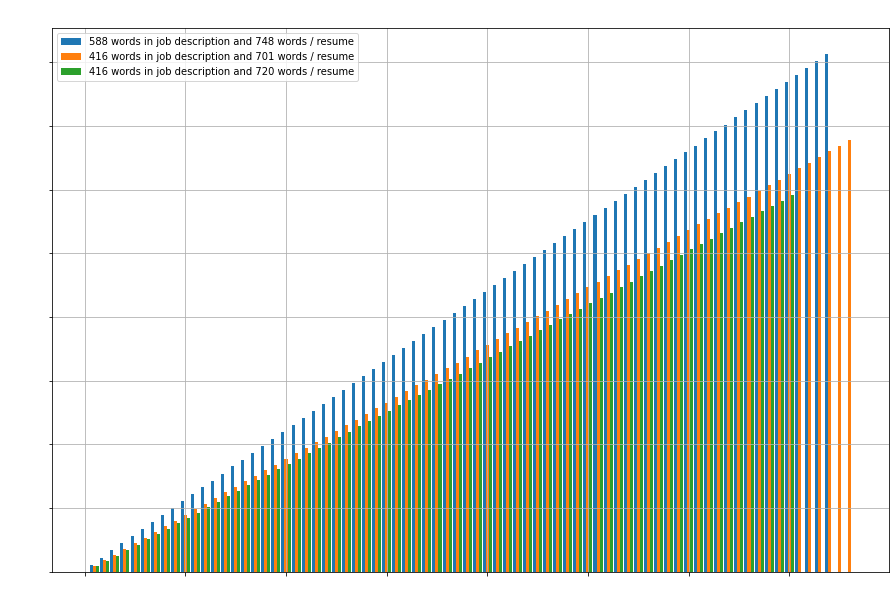

In [53]:
plt.figure(figsize = (15, 10))
plt.xlabel("Number of resumes", fontdict={'size' : 15, 'color':'white'})
plt.ylabel("Required time", fontdict = {'size' : 15, 'color':'white'})
plt.title("Comparison between time compexities", 
          fontdict = {'size': 20,
                      'color':'white'})
plt.grid("True")

w = 0.3


plt.bar(np.array(number_of_resumes_1)-w,
        times_for_matches_job_description_1,
        width = w,
        label = '588 words in job description and 748 words / resume')


plt.bar(np.array(number_of_resumes_2),
        times_for_matches_job_description_2 ,
        width = w,
        label = '416 words in job description and 701 words / resume')


plt.bar(np.array(number_of_resumes_3)+w,
        times_for_matches_job_description_3,
        width = w,
        label = '416 words in job description and 720 words / resume')

plt.xticks(color = 'white')
plt.yticks(color = 'white')

plt.legend()
plt.savefig('experiment_2_final_results.png')

In [54]:


job_descriptions_words = [588,416,416,588,416,416,588,416,416,588,416,416,588,416,416]
words_resume =           [748,701,720,748,701,720,748,701,720,748,701,720,748,701,720]
res_number =             [1,1,1,5,5,5,10,10,10,25,25,25,50,55,50]
indexes =                [1,5,10,25,50]
res_times = []
for i in indexes:
  res_times.append(times_for_matches_job_description_1[i-1])
  res_times.append(times_for_matches_job_description_2[i-1])
  res_times.append(times_for_matches_job_description_3[i-1])




d = {'Words in job description':job_descriptions_words,
     'Average words / resume':words_resume,
     'Number of resumes':res_number,
      'Total time(seconds)':res_times}
data_table = pd.DataFrame(d)
data_table

,Words in job description,Average words / resume,Number of resumes,Total time(seconds)
0,588,748,1,5.483430
1,416,701,1,4.454002
2,416,720,1,4.216553
3,588,748,5,28.072223
4,416,701,5,22.426408
5,416,720,5,21.356483
6,588,748,10,55.359667
7,416,701,10,44.762653
8,416,720,10,42.289248
9,588,748,25,137.107765


##Third experiment

In this section we present the results for the entire 220 resumes dataset paired with every job description.

In [55]:
all_resumes = []

for j_d in documents.keys():
  resumes = documents[j_d]['resumes']
  for resume in resumes:
    all_resumes.append(resume['text'])
len(all_resumes)

220

In [0]:
total_resumes_times_job_description_1 = []
total_resumes_times_job_description_2 = []
total_resumes_times_job_description_3 = []

job_description_1 = documents["Candidatul_ideal##03-04-2020  18-06-16_SET"]['job_description']['text']
job_description_2 = documents["Job_Description_3##03-04-2020  18-11-36_SET"]['job_description']['text']
job_description_3 = documents["We_are_looking_for_a_Big_Data_Engineer##03-04-2020  18-10-16_SET"]['job_description']['text']



for resume in all_resumes:
  start = timer()
  score = match_and_calculate(job_description_1,resume) 
  end = timer()
  total_resumes_times_job_description_1.append(end-start)

  start = timer()
  score = match_and_calculate(job_description_2,resume) 
  end = timer()
  total_resumes_times_job_description_2.append(end-start)

  start = timer()
  score = match_and_calculate(job_description_3,resume) 
  end = timer()
  total_resumes_times_job_description_3.append(end-start)



In [0]:
total_resumes = [i+1 for i in range(len(total_resumes_times_job_description_1))]

In [58]:
aux_1 = total_resumes_times_job_description_1.copy()

for i in range(len(total_resumes_times_job_description_1)-1,0,-1):
  total = 0
  for j in range(i+1):
    total  = total +  total_resumes_times_job_description_1[j]
  aux_1[i] = total

len(aux_1)

220

In [59]:
aux_2 = total_resumes_times_job_description_2.copy()

for i in range(len(total_resumes_times_job_description_2)-1,0,-1):
  total = 0
  for j in range(i+1):
    total  = total +  total_resumes_times_job_description_2[j]
  aux_2[i] = total

len(aux_2)

220

In [60]:
aux_3 = total_resumes_times_job_description_3.copy()

for i in range(len(total_resumes_times_job_description_3)-1,0,-1):
  total = 0
  for j in range(i+1):
    total  = total +  total_resumes_times_job_description_3[j]
  aux_3[i] = total

len(aux_3)

220

##Charts for the entire dataset

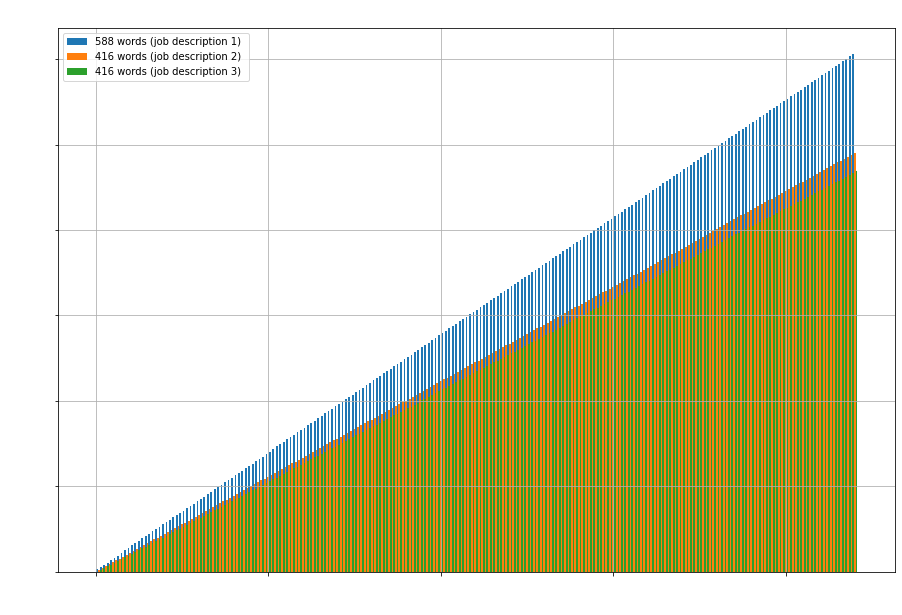

In [62]:


plt.figure(figsize = (15, 10))
plt.xlabel("Number of resumes", fontdict={'size' : 15, 'color':'white'})
plt.ylabel("Required time", fontdict = {'size' : 15, 'color':'white'})
plt.title("Comparison between time compexities", 
          fontdict = {'size': 20,
                      'color':'white'})
plt.grid("True")

w = 0.5


plt.bar(np.array(total_resumes)-w,
        aux_1,
        width = w,
        label = '588 words (job description 1) ')


plt.bar(np.array(total_resumes),
        aux_2 ,
        width = w,
        label = '416 words (job description 2)')


plt.bar(np.array(total_resumes)+w,
        aux_3,
        width = w,
        label = '416 words (job description 3)')

plt.xticks(color = 'white')
plt.yticks(color = 'white')

plt.legend()
plt.savefig('third_experiment_final_results_bar.png')

In [0]:


plt.figure(figsize = (15, 10))
plt.xlabel("Number of resumes", fontdict={'size' : 15, 'color':'white'})
plt.ylabel("Required time(seconds)", fontdict = {'size' : 15, 'color':'white'})
plt.title("Comparison between time compexities", 
          fontdict = {'size': 20,
                      'color':'white'})
plt.grid("True")

w = 0.5


plt.plot(np.array(total_resumes)-w,
        aux_1,
    
        label = '588 words (job description 1) ')


plt.plot(np.array(total_resumes),
        aux_2 ,
   
        label = '416 words (job description 2)')


plt.plot(np.array(total_resumes)+w,
        aux_3,
  
        label = '416 words (job description 3)')

plt.xticks(color = 'white')
plt.yticks(color = 'white')

plt.legend()
plt.savefig('third_experiment_final_results_graph.png')

In [64]:
average_time_first_job_description = aux_1[len(aux_1)-1] / len(aux_1)
average_time_second_job_description = aux_2[len(aux_2)-1] / len(aux_2)
average_time_third_job_description = aux_3[len(aux_3)-1] / len(aux_3)




print("""
The results for constructing the ranking with all 220 resumes are as follows:
for the first job description with {} words the average time / resume was {:.2f} seconds and the total time requiered was {:.2f} minutes,
for the second job description with {} words the average time / resume was {:.2f} seconds and the total time requiered was {:.2f} minutes,
for the third job description with {} words the average time / resume was {:.2f} seconds and the total time requiered was {:.2f} minutes.
    """.format(
        len(nlp(job_description_1)),
            average_time_first_job_description,
            aux_1[len(aux_1)-1] / 60,

          len(nlp(job_description_2)),
          average_time_second_job_description,
          aux_2[len(aux_2)-1] / 60,
         
         len(nlp(job_description_3)), 
         average_time_third_job_description,
         aux_3[len(aux_3)-1] / 60
         ))


The results for constructing the ranking with all 220 resumes are as follows:
for the first job description with 588 words the average time / resume was 5.51 seconds and the total time requiered was 20.20 minutes,
for the second job description with 416 words the average time / resume was 4.46 seconds and the total time requiered was 16.35 minutes,
for the third job description with 416 words the average time / resume was 4.26 seconds and the total time requiered was 15.62 minutes.
    


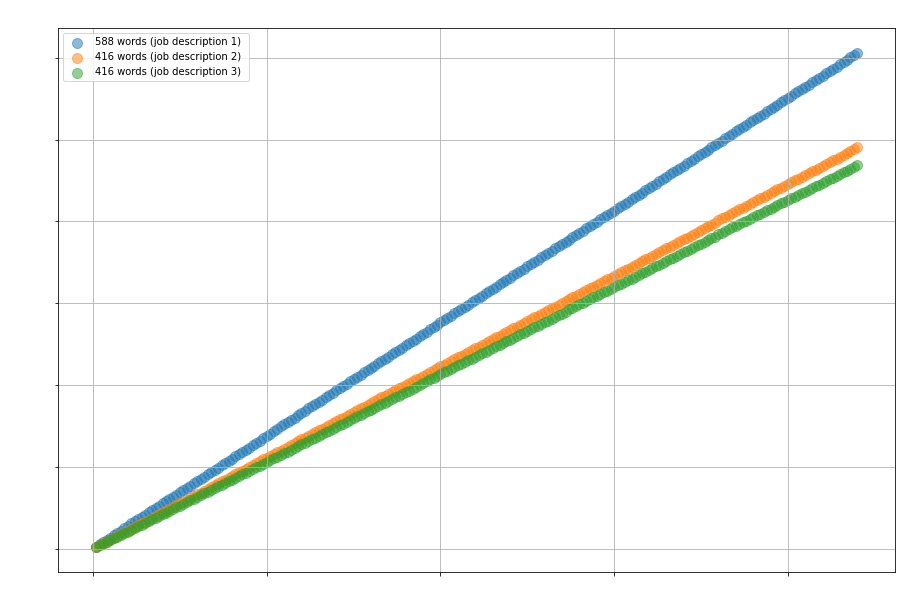

In [66]:
plt.figure(figsize = (15, 10))
plt.xlabel("Number of resumes", fontdict={'size' : 15, 'color':'white'})
plt.ylabel("Required time", fontdict = {'size' : 15, 'color':'white'})
plt.title("Comparison between time compexities", 
          fontdict = {'size': 20,
                      'color':'white'})
plt.grid("True")

w = 0.5


plt.scatter(np.array(total_resumes),
        aux_1,
        s = 100,
        alpha = 0.5,
        label = '588 words (job description 1) ')


plt.scatter(np.array(total_resumes),
        aux_2,
        s = 100,
        alpha = 0.5,
        label = '416 words (job description 2)')


plt.scatter(np.array(total_resumes),
        aux_3,
        s = 100,
        alpha = 0.5,
        label = '416 words (job description 3)')

plt.xticks(color = 'white')
plt.yticks(color = 'white')

plt.legend()
plt.savefig('third_experiment_final_results_scater.png')

From the above prezented data, we can concolude that the total required time scales up exponentialy with the number of words in the job description and liniarly with the number of resumes added. From our experiments, we found that the total time varies based not only on the number of words from the job description but also from the structure of it, the number of words from the resume being less relevant. 